c:\Users\PMLS\Documents\AQI PREDICTOR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Fetching data...
🌍 API: Fetching High-Impact Data (Weather + Pollutants)...

📋 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    4344 non-null   datetime64[ns]
 1   temperature  4344 non-null   float64       
 2   humidity     4344 non-null   int64         
 3   rain         4344 non-null   float64       
 4   wind_speed   4344 non-null   float64       
 5   wind_dir     4344 non-null   int64         
 6   pm2_5        4344 non-null   float64       
 7   pm10         4344 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 271.6 KB
None

📊 Statistics:
                           timestamp  temperature     humidity         rain  \
count                           4344  4344.000000  4344.000000  4344.000000   
mean   2025-10-11 11:30:00.000000256    26.163973    63.108425 

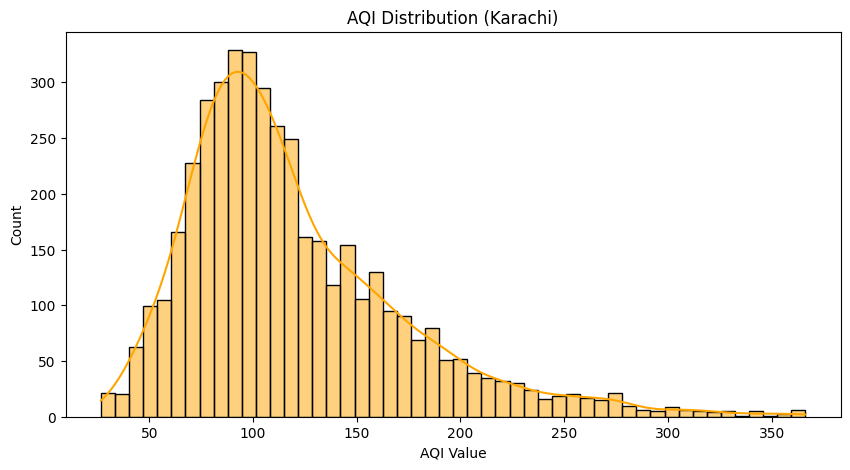

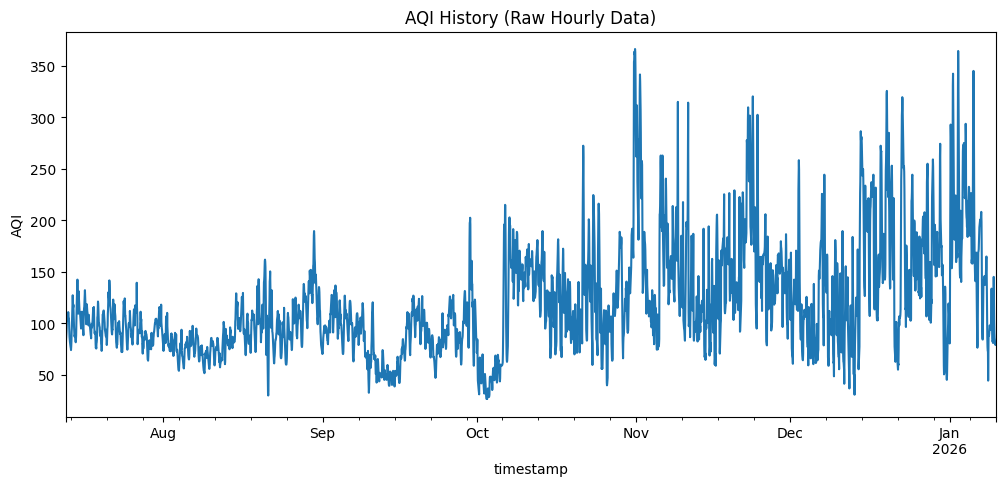

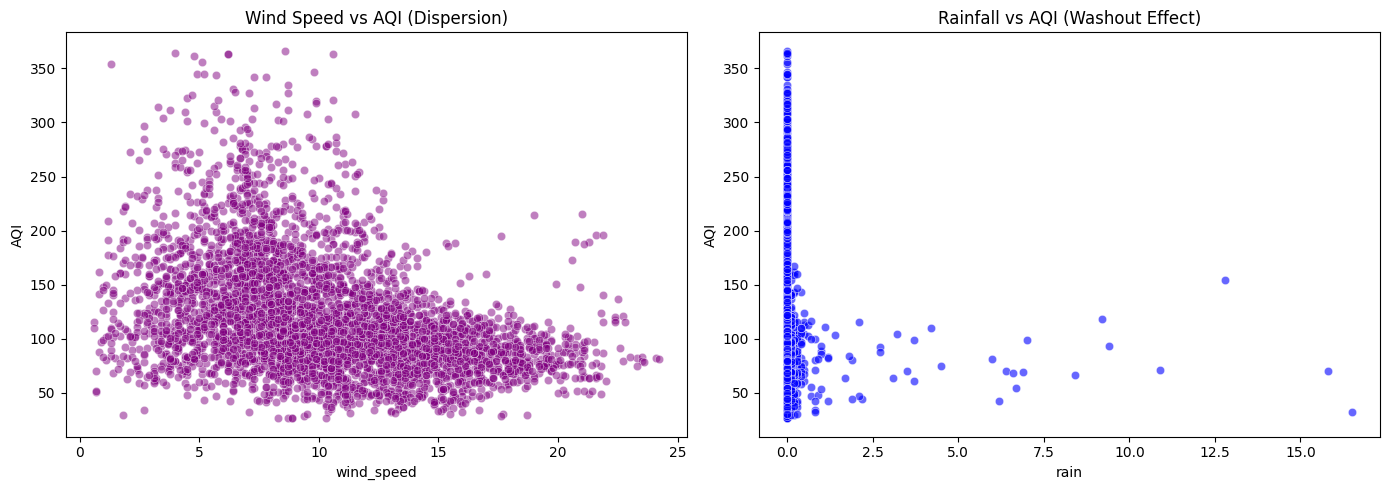

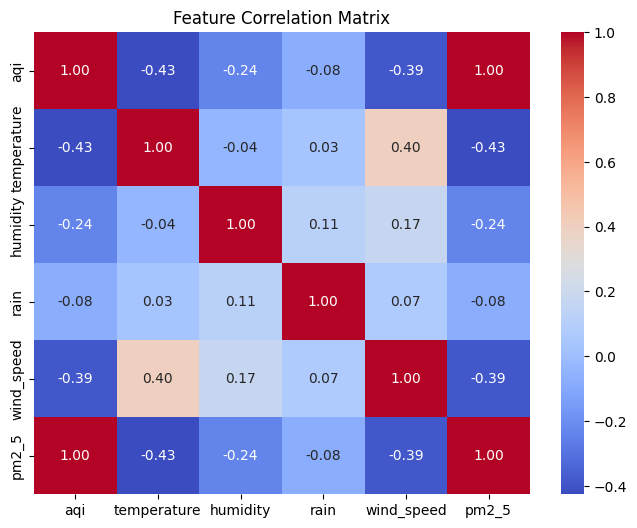

2026-01-09 19:48:12,056 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-09 19:48:12,076 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



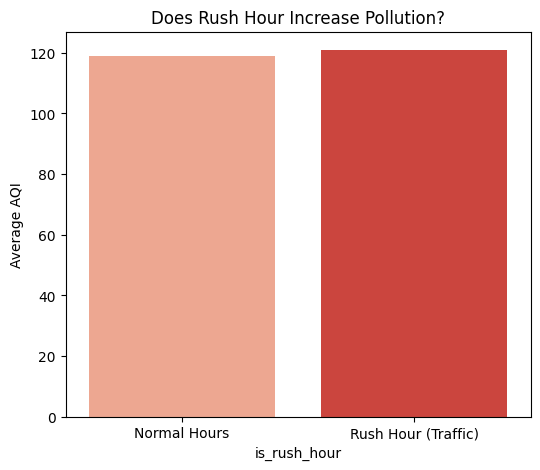

In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. FIX PATH so we can import from 'src' folder
# This tells Python: "Look in the folder above this one"
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Now this import will work!
from src.feature_pipeline import fetch_impactful_data

# -----------------------------
# LOAD DATA
# -----------------------------
print("🔄 Fetching data...")
df = fetch_impactful_data()

# -----------------------------
# BASIC CHECKS
# -----------------------------
print("\n📋 Data Info:")
print(df.info())
print("\n📊 Statistics:")
print(df.describe())

# -----------------------------
# CREATE AQI (Target Variable)
# -----------------------------
# We apply the same logic here as in your pipeline to see the result
df['aqi'] = df['pm2_5'].apply(lambda x: x * 3.8 if x > 0 else 0)

# -----------------------------
# 1. AQI DISTRIBUTION
# -----------------------------
plt.figure(figsize=(10, 5))
sns.histplot(df['aqi'], bins=50, kde=True, color='orange')
plt.title("AQI Distribution (Karachi)")
plt.xlabel("AQI Value")
plt.show()

# -----------------------------
# 2. TIME TREND
# -----------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.figure(figsize=(12, 5))
df.set_index('timestamp')['aqi'].plot()
plt.title("AQI History (Raw Hourly Data)")
plt.ylabel("AQI")
plt.show()

# -----------------------------
# 3. WEATHER IMPACT (Scatter Plots)
# -----------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Wind vs AQI
sns.scatterplot(ax=axs[0], x='wind_speed', y='aqi', data=df, alpha=0.5, color='purple')
axs[0].set_title("Wind Speed vs AQI (Dispersion)")
axs[0].set_ylabel("AQI")

# Rain vs AQI
sns.scatterplot(ax=axs[1], x='rain', y='aqi', data=df, alpha=0.6, color='blue')
axs[1].set_title("Rainfall vs AQI (Washout Effect)")
axs[1].set_ylabel("AQI")

plt.tight_layout()
plt.show()

# -----------------------------
# 4. CORRELATION HEATMAP
# -----------------------------
# Select only numeric columns that matter
corr_cols = ['aqi', 'temperature', 'humidity', 'rain', 'wind_speed', 'pm2_5']
# Filter to ensure columns exist
valid_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(8, 6))
sns.heatmap(df[valid_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# -----------------------------
# 5. RUSH HOUR ANALYSIS
# -----------------------------
df['hour'] = df['timestamp'].dt.hour
df['is_rush_hour'] = df['hour'].apply(lambda h: 1 if (8<=h<=10) or (17<=h<=20) else 0)

plt.figure(figsize=(6, 5))
sns.barplot(x='is_rush_hour', y='aqi', data=df, errorbar=None, palette="Reds")
plt.xticks([0, 1], ['Normal Hours', 'Rush Hour (Traffic)'])
plt.title("Does Rush Hour Increase Pollution?")
plt.ylabel("Average AQI")
plt.show()